In [1]:
import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

In [2]:
pyro.__version__

'1.5.1'

In [4]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [9]:
import numpy as np
import sklearn.datasets
import time
import random
import glob

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from gan_train import train_gan
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           visualize_fake_data_projection,
                           discriminator_2d_visualization,
                           mh_sampling_visualize,
                           visualize_potential_energy,
                           langevin_sampling_visualize,
                           epoch_visualization)
from mh_2d_sampling import mh_sampling
from ebm_2d_sampling import (langevin_sampling, 
                             MALA_sampling,
                             NUTS_sampling)

In [6]:
from sklearn.preprocessing import StandardScaler
random_seed = 42
train_dataset_size = 64000
sigma = 0.05

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [9]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [10]:
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [11]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [12]:
epoch = 1000
path_to_save = None
batch_size_sample = 5000  

In [13]:
G = G.to(device)
D = D.to(device)

In [14]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

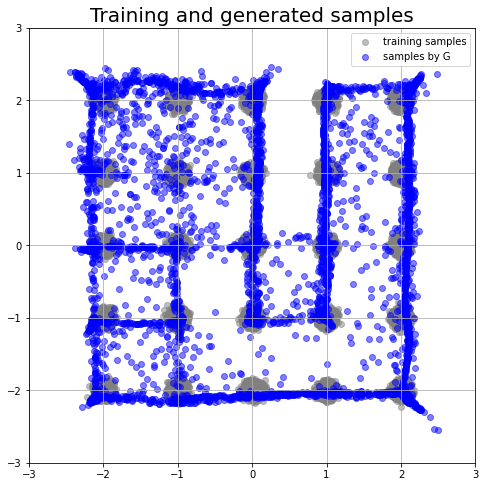

In [11]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

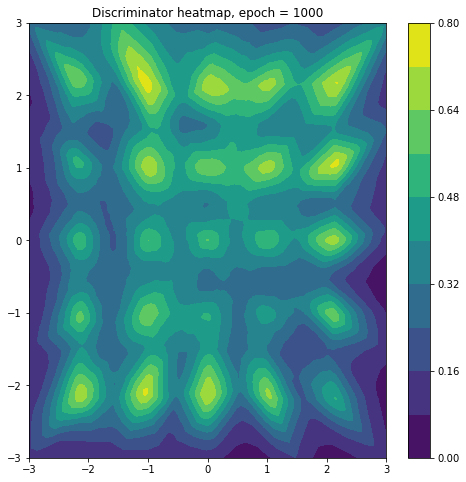

In [19]:
x_range = 3.0
y_range = 3.0
discriminator_2d_visualization(D,
                               x_range,
                               y_range,
                               path_to_save,
                               epoch,
                               scaler = scaler,
                               num_points = 700)

  0%|          | 0/5000 [00:00<?, ?it/s]

Start to do MH sampling....


100%|██████████| 5000/5000 [01:04<00:00, 77.52it/s]


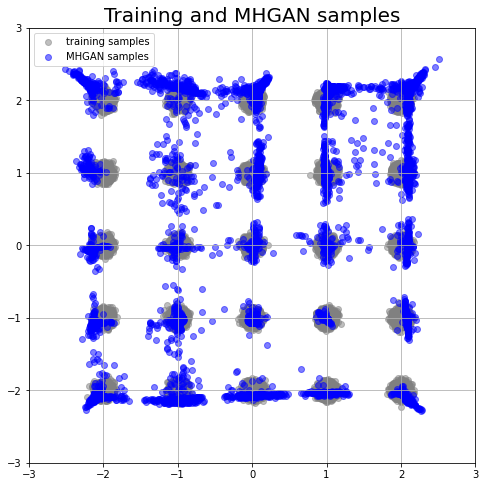

In [12]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_visualize(G, 
                      D,
                      X_train, epoch, 
                      path_to_save,
                      n_calib_pts = n_calib_pts,
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      type_calibrator = type_calibrator,
                      normalize_to_0_1 = normalize_to_0_1)

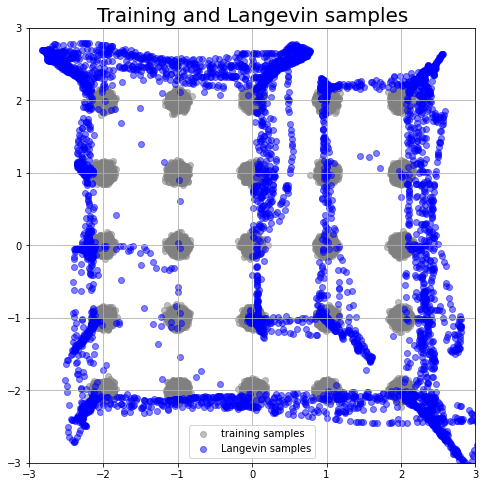

In [25]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
langevin_samples = Langevin_sampling(G, D, z_dim, eps, num_iter, device)
fake_langevin = G(langevin_samples).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(fake_langevin, X_train, mode, path_to_save, 
                    scaler = scaler)

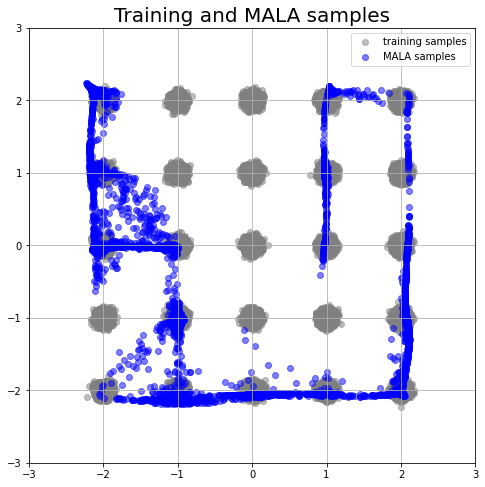

In [28]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
mala_samples = MALA_sampling(G, D, z_dim, eps, num_iter, device)
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

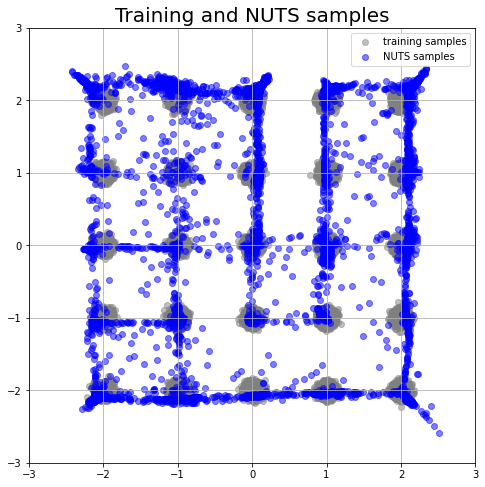

In [31]:
fake_nuts = G(nuts_samples[0]).data.cpu().numpy()
mode = 'NUTS'
plot_fake_data_mode(fake_nuts, X_train, mode, path_to_save, 
                    scaler = scaler)

100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


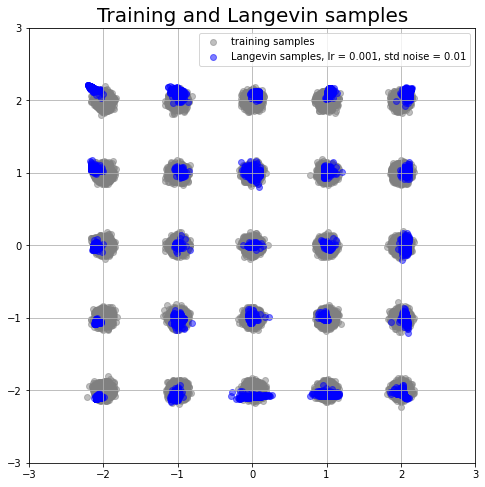

In [12]:
alpha = 1.0
step_lr = 1e-3
eps_std = 1e-2
n_steps = 5000
n_batches = 1
langevin_sampling_visualize(G, 
                            D,
                            X_train,  
                            path_to_save,
                            alpha = alpha,
                            scaler = scaler, 
                            batch_size_sample = batch_size_sample,
                            path_to_save_remote = None,
                            port_to_remote = None,
                            step_lr = step_lr,
                            eps_std = eps_std,
                            n_steps = n_steps,
                            n_batches = n_batches)

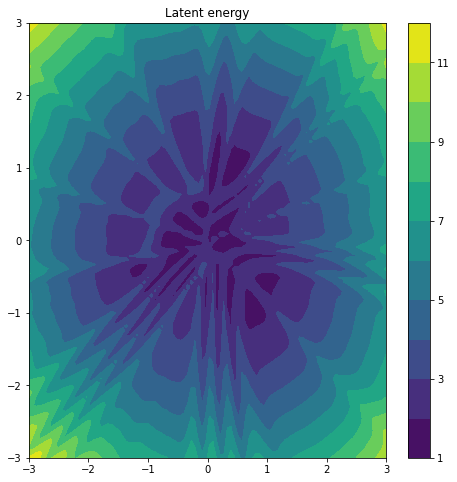

In [17]:
x_range = 3.0
y_range = 3.0
norm_grads = False
normalize_to_0_1 = True
path_to_save = None
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           path_to_save = path_to_save,
                           norm_grads = norm_grads,
                           normalize_to_0_1 = normalize_to_0_1,
                           num_points = 100)

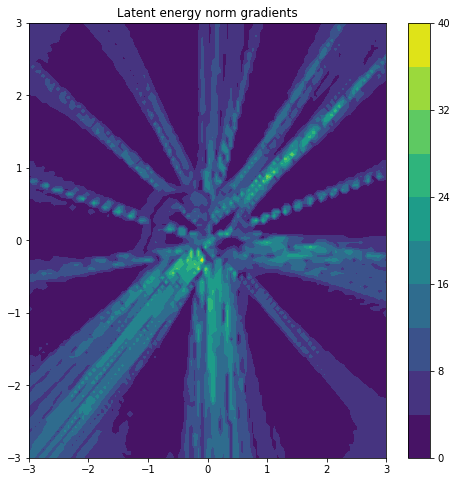

In [18]:
x_range = 3.0
y_range = 3.0
norm_grads = True
normalize_to_0_1 = True
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           norm_grads = norm_grads,
                           normalize_to_0_1 =normalize_to_0_1)

# NUTS

In [29]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [30]:
import glob
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

G = G.to(device)
D = D.to(device)
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [11]:
def calculate_energy(params, generator, discriminator, P, normalize_to_0_1, is_dict):
    if is_dict:
        params = params['points']
    generator_points = generator(params)
    if normalize_to_0_1:
        GAN_part = -discriminator(generator_points).view(-1)
    else:
        sigmoid_GAN_part = discriminator(generator_points)
        GAN_part = -(torch.log(sigmoid_GAN_part) - \
                     torch.log1p(-sigmoid_GAN_part)).view(-1)

    prior_part = -torch.sum(P.log_prob(params), dim=1)
    return (GAN_part + prior_part).sum()

n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(D.device)
normal = Normal(loc, scale)

normalize_to_0_1 = False
is_dict = True

cur_calculate_energy = partial(calculate_energy, 
                               generator = G,
                               discriminator = D,
                               P = normal,
                               normalize_to_0_1 = normalize_to_0_1,
                               is_dict = is_dict)
kernel = NUTS(potential_fn = cur_calculate_energy)

num_samples = 500
batchsize = 1

init_params = G.make_hidden(batchsize)
init_params = {'points': init_params}
mcmc = MCMC(kernel = kernel, 
            num_samples = num_samples, 
            initial_params = init_params,
            num_chains = 1)
mcmc.run()
latent_arr = mcmc.get_samples()['points']

Sample: 100%|██████████| 1000/1000 [15:04,  1.11it/s, step size=1.56e-07, acc. prob=0.566]


In [12]:
img = G(latent_arr_flatten).data.cpu().numpy()
mode = 'NUTS'
path_to_save = None
plot_fake_data_mode(img, X_train, mode, path_to_save, 
                    scaler = scaler)

NameError: name 'latent_arr_flatten' is not defined

In [21]:
latent_arr.shape

torch.Size([500, 1, 2])

In [22]:
latent_arr_flatten = latent_arr.squeeze()

In [23]:
img = G(latent_arr_flatten).data.cpu().numpy()

In [25]:
img

array([[-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 , -1.4821833 ],
       [-0.7477842 ,

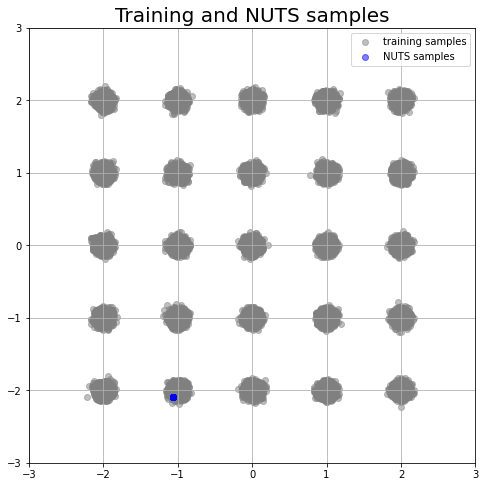

In [24]:
mode = 'NUTS'
path_to_save = None
plot_fake_data_mode(img, X_train, mode, path_to_save, 
                    scaler = scaler)

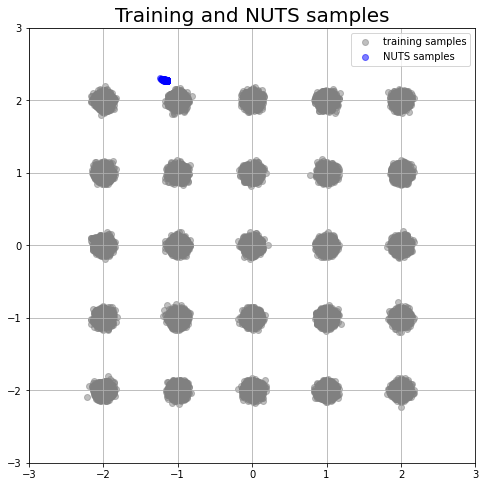

In [15]:
mode = 'NUTS'
path_to_save = None
plot_fake_data_mode(img, X_train, mode, path_to_save, 
                    scaler = scaler)

In [51]:
def calculate_energy(params, generator, discriminator, P, normalize_to_0_1, is_dict):
    if is_dict:
        params = params['points']
    generator_points = generator(params)
    if not normalize_to_0_1:
        GAN_part = -discriminator(generator_points).view(-1)
    else:
        sigmoid_GAN_part = discriminator(generator_points)
        GAN_part = -(torch.log(sigmoid_GAN_part) - \
                     torch.log1p(-sigmoid_GAN_part)).view(-1)

    prior_part = -torch.sum(P.log_prob(params), dim=1)
    return GAN_part + prior_part

In [52]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

G = G.to(device)
D = D.to(device)

In [53]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(D.device)
normal = Normal(loc, scale)

normalize_to_0_1 = False
is_dict = True

cur_calculate_energy = partial(calculate_energy, 
                               generator = G,
                               discriminator = D,
                               P = normal,
                               normalize_to_0_1 = normalize_to_0_1,
                               is_dict = is_dict)

In [54]:
kernel = NUTS(potential_fn = cur_calculate_energy)

In [55]:
num_samples = 10
batchsize = 2

init_params = G.make_hidden(batchsize)
init_params = {'points': init_params}

In [59]:
cur_calculate_energy(init_params)

tensor([2.5581, 4.2977], device='cuda:0', grad_fn=<AddBackward0>)

In [57]:
mcmc = MCMC(kernel = kernel, 
            num_samples = num_samples, 
            initial_params = init_params,
            num_chains = batchsize)

In [58]:
mcmc.run()

KeyboardInterrupt: 

In [79]:
device = 'cpu'
target = torch.distributions.Normal(loc=torch.tensor([10., 10.], device=device, dtype=torch.float32),
                                    scale=torch.tensor([1., 1.], device=device, dtype=torch.float32))

In [80]:
def potential_fn(samples):
    return -target.log_prob(samples['points']).sum(-1)

In [81]:
nuts = NUTS(potential_fn=potential_fn)

In [82]:
num_chains = 10
initial_params = {'points': torch.randn((num_chains, 2), dtype=torch.float32, device=device)}

In [83]:
mcmc = MCMC(kernel=nuts, num_samples=100, warmup_steps=100,
            initial_params=initial_params, num_chains=num_chains)

In [ ]:
mcmc.run()